In [1]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt


In [2]:
# Load the training dataset
train_data = pd.read_csv('soc-redditHyperlinks-body.tsv', delimiter='\t')

Older version of the code, using a helper dict

Newer, more sophisticated version

In [4]:
# Create a directed graph using NetworkX
G = nx.MultiDiGraph()

# Iterate through the training data to build the graph and add sentiment information as edge attributes
for index, row in train_data.iterrows():
    source_subreddit = row['SOURCE_SUBREDDIT']
    target_subreddit = row['TARGET_SUBREDDIT']
    sentiment = row['LINK_SENTIMENT']

    # Add nodes (subreddits) to the graph
    G.add_node(source_subreddit)
    G.add_node(target_subreddit)

    # Add an edge and include sentiment information as an attribute
    G.add_edge(source_subreddit, target_subreddit, sentiment=sentiment)

In [176]:
confidence_threshold = 0.5

In [177]:
def calculate_edge_sentiment(edge_data): # Return sentiment ratio of edges 
    sentiment_list = [inner['sentiment'] for inner in edge_data.values()]
    if sentiment_list: # If the list has values
        if sentiment_list.count(1) > sentiment_list.count(-1): # If there are more positive than negative
            return sentiment_list.count(1) / len(sentiment_list) # Return positive score
        if sentiment_list.count(1) < sentiment_list.count(-1): # If less positive than negative
            return -(sentiment_list.count(1) / len(sentiment_list)) # Return negative score
        if sentiment_list.count(1) == sentiment_list.count(-1): # If same
            return 0.5 # Return same
    else:
        average_sentiment = 0
    return average_sentiment

def calculate_node_sentiment_src(node): # Return mean of sentiment ratios (positive) going out of the node
    sentiment_list = []
    # Iterate over outgoing edges from the node
    for neighbor in G.successors(node):
        edge_data = G.get_edge_data(node, neighbor) # Get edge data
        edge_list = [inner['sentiment'] for inner in edge_data.values()] # Extract list of edge data
        sentiment_list.append(edge_list) # Append to full source sentiment list

    if sentiment_list: # If the list has values
        if sentiment_list.count(1) > sentiment_list.count(-1): # If there are more positive than negative
            return sentiment_list.count(1) / len(sentiment_list) # Return positive score
        if sentiment_list.count(1) < sentiment_list.count(-1): # If less positive than negative
            return -(sentiment_list.count(1) / len(sentiment_list)) # Return negative score
        if sentiment_list.count(1) == sentiment_list.count(-1): # If same
            return 0.5 # Return same
    else:
        average_sentiment = 0
    return average_sentiment

def calculate_node_sentiment_trgt(node): # Return mean of sentiment ratios (positive) targeted at the node
    sentiment_list = []
    # Iterate over outgoing edges from the node
    for neighbor in G.predecessors(node):
        edge_data = G.get_edge_data(neighbor, node) # Get edge data
        edge_list = [inner['sentiment'] for inner in edge_data.values()] # Extract list of edge data
        sentiment_list.append(edge_list) # Append to full source sentiment list

    if sentiment_list: # If the list has values
        if sentiment_list.count(1) > sentiment_list.count(-1): # If there are more positive than negative
            return sentiment_list.count(1) / len(sentiment_list) # Return positive score
        if sentiment_list.count(1) < sentiment_list.count(-1): # If less positive than negative
            return -(sentiment_list.count(1) / len(sentiment_list)) # Return negative score
        if sentiment_list.count(1) == sentiment_list.count(-1): # If same
            return 0.5 # Return same
    else:
        average_sentiment = 0
    return average_sentiment

# Predict sentiment for test set posts based on graph heuristics
def predict_sentiment(source_subreddit, target_subreddit):
    # Initialize sentiment scores as 0
    sentiment_edge, sentiment_src, sentiment_trgt= 0, 0, 0
    # Check if source or target are in G.nodes().
    # Accumulate sentiment values
    if G.has_edge(source_subreddit, target_subreddit):
        sentiment_edge = calculate_edge_sentiment(G.get_edge_data(source_subreddit, target_subreddit))
    if G.has_node(source_subreddit):
        sentiment_src = calculate_node_sentiment_src(source_subreddit)
    if G.has_node(target_subreddit):
        sentiment_trgt = calculate_node_sentiment_trgt(target_subreddit)

    # Calculate total sentiment score
    value_list_nz = [value for value in [sentiment_edge, sentiment_src, sentiment_trgt] if value != 0]
    confidence, prediction = 0, 0
    if value_list_nz:
        confidence = sum(value_list_nz) / len(value_list_nz)
    else:
        confidence = -1  # This happens only when the node doesn't exist as source nor target
        return prediction, confidence
    if confidence == 0:
        prediction = 0
    elif confidence >= confidence_threshold: # Prediction is 'generous', as the interactions overall are much more likely to be positive
        prediction = 1
    elif confidence < confidence_threshold:
        prediction = -1
    return prediction, confidence


In [191]:

# Load the test dataset
test_data = pd.read_csv('soc-redditHyperlinks-body.tsv', delimiter='\t')

# Predict sentiment for test set posts using the graph-based heuristic
test_data['PREDICTED_SENTIMENT'], test_data['CONFIDENCE'] = zip(*test_data.apply(lambda row: predict_sentiment(row['SOURCE_SUBREDDIT'], row['TARGET_SUBREDDIT']), axis=1))

# Create a new DataFrame with specific columns
result_df = test_data[['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'LINK_SENTIMENT', 'PREDICTED_SENTIMENT', 'CONFIDENCE']]

# Save the result DataFrame to a CSV file
result_df.to_csv(f'graph_data/result_data{int(confidence_threshold*100)}.csv', index=False)

In [192]:
wrongs = result_df[(result_df['CONFIDENCE'] > -1) & (result_df['LINK_SENTIMENT'] != result_df['PREDICTED_SENTIMENT'])] # 
false_neg = wrongs[wrongs['LINK_SENTIMENT'] == -1]
false_pos = wrongs[wrongs['LINK_SENTIMENT'] == 1]

In [193]:
print(len(false_pos))
false_pos.sample(n=10)

534


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT,PREDICTED_SENTIMENT,CONFIDENCE
41967,wherearethefeminists,askfeminists,1,-1,0.200000
142458,garbagesociety,blackpeopletwitter,1,-1,0.200000
175165,shitalarmistssay,climate,1,-1,0.190476
172535,copypasta,askphilosophy,1,-1,0.222222
160650,exmuslim,debatereligion,1,-1,0.190476
207055,relationships,depression,1,-1,0.238095
74927,subredditdrama,ainbow,1,-1,0.212121
225618,targetedindividuals,gangstalking,1,-1,0.238095
229263,mensrights,adviceanimals,1,-1,0.190476
67774,confession,askreddit,1,-1,0.190476


In [194]:
print(len(false_neg))
false_neg.sample(n=10)

19604


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT,PREDICTED_SENTIMENT,CONFIDENCE
142724,explainlikeimfive,wtf,-1,1,0.626667
222903,subredditdrama,legaladvice,-1,1,0.539216
255964,writingprompts,askreddit,-1,1,0.577558
23897,askreddit,jmu,-1,1,0.500000
265821,rossmannrepairgroup,googlepixel,-1,1,0.500000
227454,exmuslim,casualiama,-1,1,0.555556
59102,addiction,stopgaming,-1,1,0.500000
246905,amifat,gainers,-1,1,0.500000
183297,subredditdrama,comicbooks,-1,1,0.575758
261757,todayibullshitted,gaming,-1,1,0.500000


In [195]:
print(len(wrongs))
test = result_df[result_df['LINK_SENTIMENT'] == -1]
print(len(test))
wrongs.sort_values(by='CONFIDENCE').sample(n=10)

20138
20688


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT,PREDICTED_SENTIMENT,CONFIDENCE
13318,srsgaming,canada,-1,1,0.500000
66050,subredditdrama,tinder,1,-1,0.259259
57552,basicincome,todayilearned,-1,1,0.500000
53088,shitstatistssay,australia,-1,1,0.500000
40301,askphysics,physics,-1,1,0.633333
201156,boocredux,mgtow,-1,1,0.500000
265498,legaladvice,assistance,-1,1,0.600000
266997,kopiernudeln,me_irl,-1,1,0.500000
116209,explainlikeimfive,askreddit,-1,1,0.630081
18926,atlantahawks,bostonceltics,-1,1,0.555556


Below should be deprecated, as visualizing this graph is not recommended. See the provided 'large_graph.png' for how awful it is.

In [ ]:
# # Draw and display the graph
# pos = nx.spring_layout(G)  # Layout for node positioning
# labels = {node: node for node in G.nodes()}  # Label nodes with their names

# plt.figure(figsize=(12, 8))
# # This will take very long for the size of the graph, trying to save to file further down with less nodes
# nx.draw(G, pos, with_labels=True, labels=labels, node_size=50, node_color='skyblue', font_size=6, font_color='black', edge_color='gray', width=0.5, arrowsize=10)

# plt.title("Directed Social Graph of Subreddits")
# plt.axis('off')  # Turn off axis labels

# plt.show()

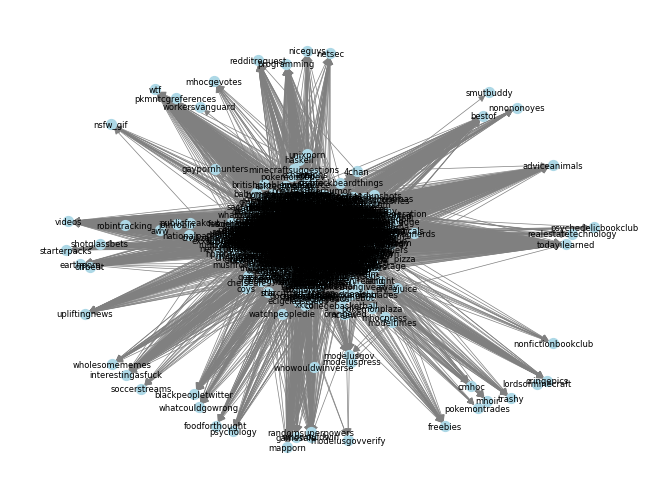

In [ ]:
# # Calculate the degree (number of edges) for each node
# degrees = dict(G.degree())

In [ ]:
# # Define a threshold for the minimum number of edges to display a node
# threshold = 0

# # Create a list of nodes that meet the threshold
# selected_nodes = [node for node, degree in degrees.items() if degree >= threshold]

# fig, ax = plt.subplots(figsize=(150, 150), dpi=300)

# # Create a subgraph with only the selected nodes and their edges
# subgraph = G.subgraph(selected_nodes)

# # Plot the subgraph
# pos = nx.spring_layout(subgraph)
# nx.draw(subgraph, pos, with_labels=True, font_size=6, node_color='lightblue', edge_color='gray', width = 0.5, node_size=50, arrowsize=10)
# plt.savefig('large_graph.png', format='png', bbox_inches='tight')
# # Resulting graph is not really a good representation, still added here for completeness sake
# #plt.show()